<a href="https://colab.research.google.com/github/zuti666/generative-models/blob/master/Tips_for_Improving_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tips for Improving GAN

## 在实际中，任何两个manifolds都不会perfectly align.

首先是，为什么生成样本和真实样本很难有不可忽略的重叠部分？

![image-20211114183831684](https://zuti.oss-cn-qingdao.aliyuncs.com/img/image-20211114183831684.png)



但是如果两个分布完全没有重叠的部分，或者它们重叠的部分可忽略，

**理解**：

GAN中的生成器一般是从某个低维（比如100维）的随机分布中采样出一个编码向量，再经过一个神经网络生成出一个高维样本（比如64x64的图片就有4096维)。当生成器的参数固定时，生成样本的概率分布虽然是定义在4096维的空间上，但它本身所有可能产生的变化已经被那个100维的随机分布限定了，其本质维度就是100，再考虑到神经网络带来的映射降维，最终可能比100还小，所以生成样本分布的支撑集就在4096维空间中构成一个最多100维的低维流形，“撑不满”整个高维空间。

“撑不满”就会导致真实分布与生成分布难以“碰到面”，这很容易在二维空间中理解：一方面，二维平面中随机取两条曲线，它们之间刚好存在重叠线段的概率为0；另一方面，虽然它们很大可能会存在交叉点，但是相比于两条曲线而言，交叉点比曲线低一个维度，长度（测度）为0，可忽略。三维空间中也是类似的，随机取两个曲面，它们之间最多就是比较有可能存在交叉线，但是交叉线比曲面低一个维度，面积（测度）是0，可忽略。

从低维空间拓展到高维空间，就有了如下逻辑：因为一开始生成器随机初始化，所以![[公式]](https://www.zhihu.com/equation?tex=P_g)几乎不可能与![[公式]](https://www.zhihu.com/equation?tex=P_r)有什么关联，所以它们的支撑集之间的重叠部分要么不存在，要么就比![[公式]](https://www.zhihu.com/equation?tex=P_r)和![[公式]](https://www.zhihu.com/equation?tex=P_g)的最小维度还要低至少一个维度，故而测度为0。

另一个理解：即使存在重叠，但是我们是一个取样的过程，所以会出现即使出现重叠，但并不能充分表现出来

# TOWARDS PRINCIPLED METHODS FOR TRAINING GENERATIVE ADVERSARIAL NETWORKS  

## 论文
[[1701.04862\] Towards Principled Methods for Training Generative Adversarial Networks (arxiv.org)](https://arxiv.org/abs/1701.04862)

## 主要思想

针对第二点提出了一个解决方案，就是对生成样本和真实样本加噪声，直观上说，使得原本的两个低维流形“弥散”到整个高维空间，强行让它们产生不可忽略的重叠。而一旦存在重叠，JS散度就能真正发挥作用，此时如果两个分布越靠近，它们“弥散”出来的部分重叠得越多，JS散度也会越小而不会一直是一个常数，于是（在第一种原始GAN形式下）梯度消失的问题就解决了。在训练过程中，我们可以对所加的噪声进行退火（annealing），慢慢减小其方差，到后面两个低维流形“本体”都已经有重叠时，就算把噪声完全拿掉，JS散度也能照样发挥作用，继续产生有意义的梯度把两个低维流形拉近，直到它们接近完全重合。以上是对原文的直观解释。

# LeastSquareGAN

## 论文
[Least_Squares_Generative](https://openaccess.thecvf.com/content_iccv_2017/html/Mao_Least_Squares_Generative_ICCV_2017_paper.html)

## 主要思想


![image-20211114191806698](https://zuti.oss-cn-qingdao.aliyuncs.com/img/image-20211114191806698.png)

鉴别器做的实际是一个二分类问题，判别函数就是Sigmoid函数，但是我们从Sigmoid函数可以看出，当鉴别器具有很好的分类效果时，对应图像的梯度几乎为0，也就是出现了梯度消失的问题。

LSGAN就用线性函数代替Sigmoid函数，将一个分类问题变成了一个拟合问题，根据拟合的结果对样本进行分类。

![image-20231006110711134](https://zuti.oss-cn-qingdao.aliyuncs.com/img/20231006110711.png)

## 公式


![image-20231006111330489](https://zuti.oss-cn-qingdao.aliyuncs.com/img/20231006111330.png)



![image-20231004163208778](https://zuti.oss-cn-qingdao.aliyuncs.com/img/20231004163208.png)

![image-20231006111012049](https://zuti.oss-cn-qingdao.aliyuncs.com/img/20231006111012.png)

证明 LSGANs and the Pearson χ2 divergence 的关系

![image-20231006110914984](https://zuti.oss-cn-qingdao.aliyuncs.com/img/20231006110915.png)

![image-20231006110926223](../../../AppData/Roaming/Typora/typora-user-images/image-20231006110926223.png)

![image-20231006110956515](https://zuti.oss-cn-qingdao.aliyuncs.com/img/20231006110956.png)


## 代码

加载库和数据

In [ ]:
# 导入必要的库
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
#from torchvision import datasets, transforms
#from torch.utils.data import DataLoader
import tensorflow as tf
import scipy.ndimage

# 定义超参数
mb_size = 32
z_dim = 10
X_dim = 784  # MNIST图像的维度
h_dim = 128
file_name = 0
lr = 1e-3  #learning rate
d_step = 3  # 判别器更新次数

# 数据转换和加载
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
X_train = train_images
X_train = X_train.reshape(-1, 28*28)


定义生成器和判别器

In [ ]:
# 定义生成器和判别器
G = nn.Sequential(
    nn.Linear(z_dim, h_dim),
    nn.ReLU(),
    nn.Linear(h_dim, X_dim),
    nn.Sigmoid()
)

D = nn.Sequential(
    nn.Linear(X_dim, h_dim),
    nn.ReLU(),
    nn.Linear(h_dim, 1),
)

# 损失函数和优化器
G_solver = optim.Adam(G.parameters(), lr=lr)
D_solver = optim.Adam(D.parameters(), lr=lr)

# 辅助函数
def reset_grad():
    G.zero_grad()
    D.zero_grad()

进行训练

Iter-0; D_loss: 131.4; G_loss: 0.5808


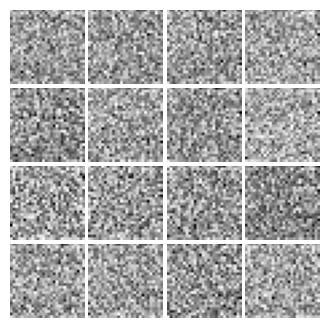

Iter-1000; D_loss: 0.03479; G_loss: 0.4837


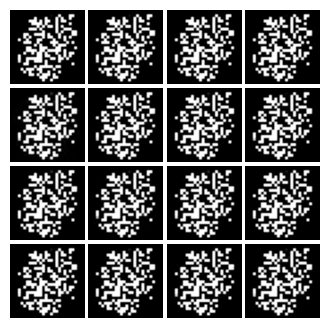

Iter-2000; D_loss: 0.00782; G_loss: 0.4887


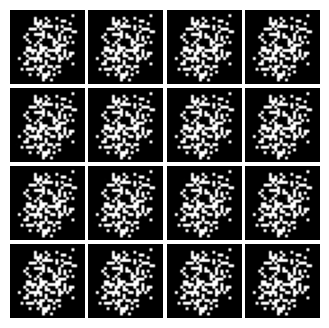

Iter-3000; D_loss: 0.01227; G_loss: 0.4824


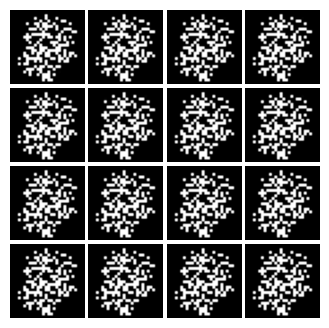

Iter-4000; D_loss: 0.01546; G_loss: 0.4739


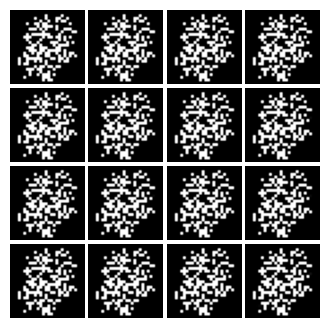

Iter-5000; D_loss: 0.01852; G_loss: 0.4771


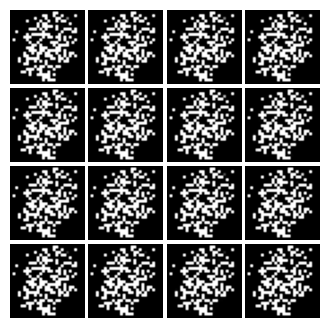

Iter-6000; D_loss: 0.005037; G_loss: 0.4803


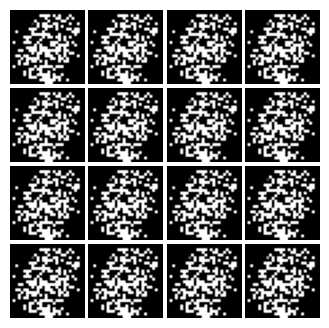

Iter-7000; D_loss: 0.02028; G_loss: 0.4811


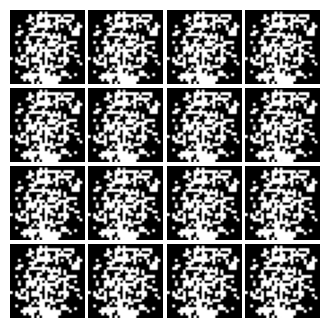

Iter-8000; D_loss: 0.01582; G_loss: 0.4832


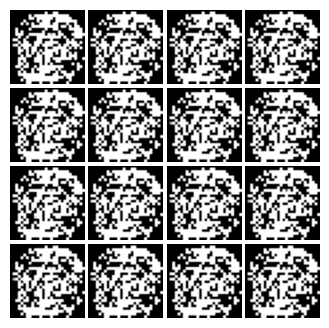

Iter-9000; D_loss: 0.008416; G_loss: 0.4839


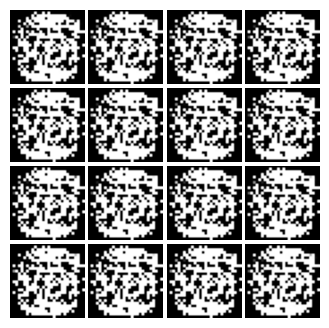

Iter-10000; D_loss: 0.009858; G_loss: 0.4835


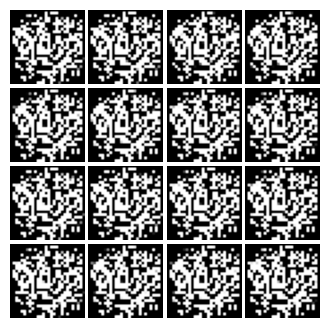

KeyboardInterrupt: ignored

In [ ]:
def sample_x(X, size):
    start_idx = np.random.randint(0, X.shape[0]-size)
    return Variable(torch.from_numpy(X[start_idx:start_idx+size]))


for it in range(1000000):
    for _ in range(d_step):
        # Sample data
        z =  Variable(torch.randn(mb_size, z_dim))
        X = sample_x(X_train, mb_size)
        X =  X.float()

        # Dicriminator
        G_sample = G(z)
        D_real = D(X)
        D_fake = D(G_sample)

        # 损失函数定义改变
        D_loss = 0.5 * (torch.mean((D_real - 1)**2) + torch.mean(D_fake**2))

        D_loss.backward()
        D_solver.step()
        reset_grad()

    # Generator
    z = Variable(torch.randn(mb_size, z_dim))

    G_sample = G(z)
    D_fake = D(G_sample)

    G_loss = 0.5 * torch.mean((D_fake - 1)**2)

    G_loss.backward()
    G_solver.step()
    reset_grad()

    # Print and plot every now and then
    if it % 1000 == 0:
        print('Iter-{}; D_loss: {:.4}; G_loss: {:.4}'.format(it, D_loss.item(), G_loss.item()))

        samples = G(z).data.numpy()[:16]

        fig = plt.figure(figsize=(4, 4))
        gs = gridspec.GridSpec(4, 4)
        gs.update(wspace=0.05, hspace=0.05)

        for i, sample in enumerate(samples):
            ax = plt.subplot(gs[i])
            plt.axis('off')
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_aspect('equal')
            plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

        if not os.path.exists('out/'):
            os.makedirs('out/')

        plt.savefig('out/{}.png'.format(str(file_name).zfill(3)), bbox_inches='tight')
        plt.show()
        file_name += 1
        plt.close(fig)

# Softmax_GAN

## 论文
[[1704.06191\] Softmax GAN (arxiv.org)](https://arxiv.org/abs/1704.06191)

## 公式


![image-20231006115804152](https://zuti.oss-cn-qingdao.aliyuncs.com/img/20231006115804.png)

![image-20231006115817315](https://zuti.oss-cn-qingdao.aliyuncs.com/img/20231006115817.png)



## 代码

加载数据和库

In [ ]:
# 导入必要的库
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
#from torchvision import datasets, transforms
#from torch.utils.data import DataLoader
import tensorflow as tf
import scipy.ndimage

# 定义超参数
mb_size = 32
z_dim = 10
X_dim = 784  # MNIST图像的维度
h_dim = 128
file_name = 0
lr = 1e-3  #learning rate
d_step = 3  # 判别器更新次数

# 数据转换和加载
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
X_train = train_images
X_train = X_train.reshape(-1, 28*28)

定义生成器和判别器

In [ ]:

G = torch.nn.Sequential(
    torch.nn.Linear(z_dim, h_dim),
    torch.nn.ReLU(),
    torch.nn.Linear(h_dim, X_dim),
    torch.nn.Sigmoid()
)


D = torch.nn.Sequential(
    torch.nn.Linear(X_dim, h_dim),
    torch.nn.ReLU(),
    torch.nn.Linear(h_dim, 1)
)


def reset_grad():
    G.zero_grad()
    D.zero_grad()


G_solver = optim.Adam(G.parameters(), lr=lr)
D_solver = optim.Adam(D.parameters(), lr=lr)


D_target = 1./mb_size
G_target = 1./(mb_size*2)


定义辅助函数


In [ ]:

def log(x):
    return torch.log(x + 1e-8)

def sample_x(X, size):
    start_idx = np.random.randint(0, X.shape[0]-size)
    return Variable(torch.from_numpy(X[start_idx:start_idx+size]))

开始训练

In [ ]:
torch.autograd.set_detect_anomaly(True)

for it in range(1000000):
    # Sample data
    z = Variable(torch.randn(mb_size, z_dim))
    X = sample_x(X_train, mb_size)
    X =  X.float()

    G_sample = G(z)
    D_real = D(X)
    D_fake = D(G_sample)

    # Partition func.
    Z = torch.sum(torch.exp(-D_real)) + torch.sum(torch.exp(-D_fake))

    # Dicriminator
    D_loss = torch.sum(D_target * D_real) + log(Z)

    D_loss.backward(retain_graph=True)
    D_solver.step()
    reset_grad()

    # Generator
    G_loss = torch.sum(G_target * D_real) + torch.sum(G_target * D_fake) + log(Z)

    G_loss.backward()
    G_solver.step()
    reset_grad()

    # Print and plot every now and then
    if it % 1000 == 0:
        print('Iter-{}; D_loss: {:.4}; G_loss: {:.4}'.format(it, D_loss.item(), G_loss.item()))

        samples = G(z).data.numpy()[:16]

        fig = plt.figure(figsize=(4, 4))
        gs = gridspec.GridSpec(4, 4)
        gs.update(wspace=0.05, hspace=0.05)

        for i, sample in enumerate(samples):
            ax = plt.subplot(gs[i])
            plt.axis('off')
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_aspect('equal')
            plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

        if not os.path.exists('out/'):
            os.makedirs('out/')

        plt.savefig('out/{}.png'.format(str(file_name).zfill(3)), bbox_inches='tight')
        file_name += 1
        plt.close(fig)

/usr/local/lib/python3.10/dist-packages/torch/autograd/__init__.py:200: UserWarning: Error detected in ExpBackward0. Traceback of forward call that caused the error:
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
    self._run_once()
  File "/usr/lib/

RuntimeError: ignored

# Wasserstein GAN

## 论文
[Wasserstein Generative Adversarial Networks (mlr.press)](https://proceedings.mlr.press/v70/arjovsky17a.html)

## EarthMove Distance
![image-20211114192610826](https://zuti.oss-cn-qingdao.aliyuncs.com/img/image-20211114192610826.png)

在一维分布时，很形象

但在二维上面，事实上有很多种方法，推土机距离就是定义为穷举所有的方案，距离最小的哪个

![image-20211114192738066](https://zuti.oss-cn-qingdao.aliyuncs.com/img/image-20211114192738066.png)



![image-20211114192832997](https://zuti.oss-cn-qingdao.aliyuncs.com/img/image-20211114192832997.png)

### 正式定义

![image-20211114193646039](https://zuti.oss-cn-qingdao.aliyuncs.com/img/image-20211114193646039.png)


## Earth Mover’s Distance 的优点
![image-20211114194008576](https://zuti.oss-cn-qingdao.aliyuncs.com/img/image-20211114194008576.png)
能够衡量不相交的时候的距离，并且距离越近效果越好



## WGAN 的做法

### 使用 Wassterstein

![image-20211114194355129](https://zuti.oss-cn-qingdao.aliyuncs.com/img/image-20211114194355129.png)



$D \in 1-Lipschitz$就是要包证收敛

给出 Lipschitz Function 含义

![image-20211114194717452](https://zuti.oss-cn-qingdao.aliyuncs.com/img/image-20211114194717452.png)

在原始的WGAN中为了保持1-lipschitz，使用Weight Clipping只是给出了范围限制。但是这样并没有解决这个问题

## 公式

![image-20231006121857830](https://zuti.oss-cn-qingdao.aliyuncs.com/img/20231006121857.png)

![image-20231006122009737](https://zuti.oss-cn-qingdao.aliyuncs.com/img/20231006122009.png)

![image-20231006122038567](https://zuti.oss-cn-qingdao.aliyuncs.com/img/20231006122038.png)



## 算法流程
## 从GAN到WGAN算法的改进

**而改进后相比原始GAN的算法实现流程却只改了四点**：

- 判别器最后一层去掉sigmoid
- 生成器和判别器的loss不取log
- 每次更新判别器的参数之后把它们的绝对值截断到不超过一个固定常数c
- 不要用基于动量的优化算法（包括momentum和Adam），推荐RMSProp，SGD也行

![image-20211114213101647](https://zuti.oss-cn-qingdao.aliyuncs.com/img/image-20211114213101647.png)

![image-20231004163325428](https://zuti.oss-cn-qingdao.aliyuncs.com/img/20231004163325.png)

## 代码

导入相关的库，加载数据

In [ ]:
# 导入必要的库
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
#from torchvision import datasets, transforms
#from torch.utils.data import DataLoader
import tensorflow as tf
import scipy.ndimage

# 定义超参数
mb_size = 32
z_dim = 10
X_dim = 784  # MNIST图像的维度
h_dim = 128
file_name = 0
lr = 1e-3  #learning rate
d_step = 3  # 判别器更新次数

# 数据转换和加载
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
X_train = train_images
X_train = X_train.reshape(-1, 28*28)

定义G,D

In [ ]:
G = torch.nn.Sequential(
    torch.nn.Linear(z_dim, h_dim),
    torch.nn.ReLU(),
    torch.nn.Linear(h_dim, X_dim),
    torch.nn.Sigmoid()
)


D = torch.nn.Sequential(
    torch.nn.Linear(X_dim, h_dim),
    torch.nn.ReLU(),
    torch.nn.Linear(h_dim, 1),
)


def reset_grad():
    G.zero_grad()
    D.zero_grad()


G_solver = optim.RMSprop(G.parameters(), lr=lr)
D_solver = optim.RMSprop(D.parameters(), lr=lr)

开始训练

In [ ]:
def sample_x(X, size):
    start_idx = np.random.randint(0, X.shape[0]-size)
    return Variable(torch.from_numpy(X[start_idx:start_idx+size]))

for it in range(1000000):
    for _ in range(5):
        # Sample data
        z = Variable(torch.randn(mb_size, z_dim))
        X = sample_x(X_train, mb_size)
        X =  X.float()

        # Dicriminator forward-loss-backward-update
        G_sample = G(z)
        D_real = D(X)
        D_fake = D(G_sample)

        D_loss = -(torch.mean(D_real) - torch.mean(D_fake))

        D_loss.backward()
        D_solver.step()

        # Weight clipping
        for p in D.parameters():
            p.data.clamp_(-0.01, 0.01)

        # Housekeeping - reset gradient
        reset_grad()

    # Generator forward-loss-backward-update
    X = sample_x(X_train, mb_size)
    X =  X.float()
    z = Variable(torch.randn(mb_size, z_dim))

    G_sample = G(z)
    D_fake = D(G_sample)

    G_loss = -torch.mean(D_fake)

    G_loss.backward()
    G_solver.step()

    # Housekeeping - reset gradient
    reset_grad()

    # Print and plot every now and then
    if it % 1000 == 0:
        print('Iter-{}; D_loss: {:.4}; G_loss: {:.4}'.format(it, D_loss.item(), G_loss.item()))

        samples = G(z).data.numpy()[:16]

        fig = plt.figure(figsize=(4, 4))
        gs = gridspec.GridSpec(4, 4)
        gs.update(wspace=0.05, hspace=0.05)

        for i, sample in enumerate(samples):
            ax = plt.subplot(gs[i])
            plt.axis('off')
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_aspect('equal')
            plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

        if not os.path.exists('out/'):
            os.makedirs('out/')

        plt.savefig('out/{}.png'.format(str(file_name).zfill(3)), bbox_inches='tight')
        plt.show()
        file_name += 1
        plt.close(fig)

Iter-0; D_loss: -170.6; G_loss: -3.032
Iter-1000; D_loss: -154.1; G_loss: -3.067
Iter-2000; D_loss: -167.0; G_loss: -3.122
Iter-3000; D_loss: -160.4; G_loss: -3.079
Iter-4000; D_loss: -162.2; G_loss: -3.045
Iter-5000; D_loss: -146.7; G_loss: -3.081
Iter-6000; D_loss: -168.0; G_loss: -3.041
Iter-7000; D_loss: -161.7; G_loss: -3.157
Iter-8000; D_loss: -140.3; G_loss: -3.066
Iter-9000; D_loss: -138.7; G_loss: -3.054
Iter-10000; D_loss: -161.5; G_loss: -3.146
Iter-11000; D_loss: -166.6; G_loss: -3.094
Iter-12000; D_loss: -129.5; G_loss: -3.069
Iter-13000; D_loss: -157.1; G_loss: -3.019


KeyboardInterrupt: ignored

# Improved WGAN

## 论文
[Improved Training of Wasserstein GANs (neurips.cc)](https://proceedings.neurips.cc/paper_files/paper/2017/hash/892c3b1c6dccd52936e27cbd0ff683d6-Abstract.html)

## 主要思想
![image-20231006125601067](https://zuti.oss-cn-qingdao.aliyuncs.com/img/20231006125601.png)

![image-20211114195347226](https://zuti.oss-cn-qingdao.aliyuncs.com/img/image-20211114195347226.png)

### 对哪里进行限制—中间部分即可

![image-20231004144150938](https://zuti.oss-cn-qingdao.aliyuncs.com/img/20231004144151.png)

### 怎么进行限制 —接近1

![image-20211114212538050](https://zuti.oss-cn-qingdao.aliyuncs.com/img/image-20211114212538050.png)

## 算法流程
![image-20231006125620091](https://zuti.oss-cn-qingdao.aliyuncs.com/img/20231006125620.png)

## 代码


加载库和数据

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

# 超参数
mb_size = 32
X_dim = 784
z_dim = 10
h_dim = 128
lam = 10
n_disc = 5
lr = 1e-4

# 加载MNIST数据
mnist = tf.keras.datasets.mnist
(train_images, _), (_, _) = mnist.load_data()
X_train = train_images.reshape(-1, X_dim).astype(np.float32)
X_train /= 255.0  # 将像素值归一化到 [0, 1]



创建G ,D

In [ ]:
# 定义生成器和判别器
class Generator(tf.keras.Model):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = tf.keras.layers.Dense(h_dim, activation='relu')
        self.fc2 = tf.keras.layers.Dense(X_dim, activation='sigmoid')

    def call(self, z):
        h = self.fc1(z)
        X_fake = self.fc2(h)
        return X_fake

class Discriminator(tf.keras.Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = tf.keras.layers.Dense(h_dim, activation='relu')
        self.fc2 = tf.keras.layers.Dense(1)

    def call(self, X):
        h = self.fc1(X)
        D_logit = self.fc2(h)
        return D_logit

# 定义生成器和判别器实例
generator = Generator()
discriminator = Discriminator()

# 定义优化器
D_optimizer = tf.keras.optimizers.Adam(learning_rate=lr, beta_1=0.5)
G_optimizer = tf.keras.optimizers.Adam(learning_rate=lr, beta_1=0.5)

训练模型

Epoch: 0; D loss: -3.032; G_loss: -0.6752


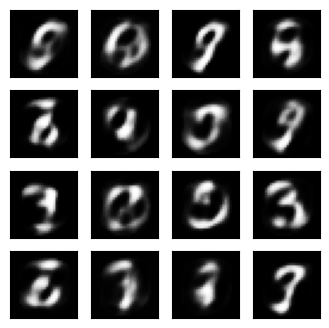

KeyboardInterrupt: ignored

In [ ]:
# 定义损失函数
def discriminator_loss(D_real, D_fake, X, G_sample):
    grad = tf.gradients(D_real, [X])[0]
    grad_norm = tf.sqrt(tf.reduce_sum((grad)**2, axis=1))
    grad_pen = lam * tf.reduce_mean((grad_norm - 1)**2)
    return tf.reduce_mean(D_fake) - tf.reduce_mean(D_real) + grad_pen

def generator_loss(D_fake):
    return -tf.reduce_mean(D_fake)

# 训练模型
@tf.function
def train_step(X):
    for _ in range(n_disc):
        with tf.GradientTape(persistent=True) as tape:
            G_sample = generator(tf.random.uniform([mb_size, z_dim], minval=-1., maxval=1.))
            D_real = discriminator(X)
            D_fake = discriminator(G_sample)
            D_loss = discriminator_loss(D_real, D_fake, X, G_sample)
        D_gradients = tape.gradient(D_loss, discriminator.trainable_variables)
        D_optimizer.apply_gradients(zip(D_gradients, discriminator.trainable_variables))

    with tf.GradientTape() as tape:
        G_sample = generator(tf.random.uniform([mb_size, z_dim], minval=-1., maxval=1.))
        D_fake = discriminator(G_sample)
        G_loss = generator_loss(D_fake)
    G_gradients = tape.gradient(G_loss, generator.trainable_variables)
    G_optimizer.apply_gradients(zip(G_gradients, generator.trainable_variables))

    return D_loss, G_loss

# 创建输出文件夹
if not os.path.exists('out/'):
    os.makedirs('out/')

# 训练参数
num_epochs = 1000000
save_interval = 1000
i = 0

for epoch in range(num_epochs):
    for _ in range(0, X_train.shape[0], mb_size):
        X_mb = X_train[_:_+mb_size]
        D_loss, G_loss = train_step(X_mb)

    if epoch % 1000 == 0:
        print('Epoch: {}; D loss: {:.4}; G_loss: {:.4}'.format(epoch, D_loss, G_loss))

    if epoch % save_interval == 0:
        samples = generator(tf.random.uniform([16, z_dim], minval=-1., maxval=1.))
        samples = samples.numpy()
        fig = plt.figure(figsize=(4, 4))
        for i in range(16):
            ax = fig.add_subplot(4, 4, i + 1)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.imshow(samples[i].reshape(28, 28), cmap='gray')
        plt.savefig('out/{}.png'.format(str(i).zfill(3)), bbox_inches='tight')
        plt.show()
        i += 1
        plt.close(fig)

# DraGAN

## 论文
[[dragan\] On Convergence and Stability of GANs (arxiv.org)](https://arxiv.org/abs/1705.07215)

## 主要思想
> **猜测模型倒塌（**mode collapse**）是由于在非凸情况下出现了局部平衡，作者观测到局部平衡总是在判别函数中的真实数据周围表现出了尖锐的梯度，因此作者提出DRAGAN，在模型中引入梯度惩罚机制以避免局部平衡。**
>
> 模型倒塌的原因前面也介绍过了，这种尖锐的梯度，会使得多个z矢量映射到单个输出x，造成博弈的退化平衡（实际表现出来也就是输入的多组变量都会产生一致的结果），为了减少这种现象，可以对判别器添加惩罚项：
>
> ![image-20231004171402528](https://zuti.oss-cn-qingdao.aliyuncs.com/img/20231004171402.png)
>
> 这个方法也确实能够提高模型训练的稳定性。这也解释了为什么WGAN能一定程度上解决模型倒塌，进一步的研究，这种机制非常难达到，一旦过度惩罚（over-penalized），判别器则会引入一些噪声，因此更好的惩罚项应该如下设置：
>
> ![image-20231004171409729](https://zuti.oss-cn-qingdao.aliyuncs.com/img/20231004171409.png)
>
> 最后，出于一些经验性的优化考虑，作者最终所采用的惩罚项为：
>
> ![image-20231004171419026](https://zuti.oss-cn-qingdao.aliyuncs.com/img/20231004171419.png)



## 代码


加载库

In [ ]:
# 导入所需的库
import numpy as np
import torch
from torch.autograd import Variable, grad
from torch.nn.init import xavier_normal
from torchvision import datasets, transforms
import torchvision.utils as vutils

# 设置超参数
batch_size = 32
z_dim = 100
h_dim = 128
y_dim = 28 * 28
max_epochs = 1000
lambda_ = 10

# 加载训练和测试数据集
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=batch_size, shuffle=False, drop_last=True)

创建 G，D

In [ ]:
# 创建生成器和鉴别器模型
# 定义生成器类
class Generator(torch.nn.Module):
    def __init__(self, z_dim, h_dim, y_dim):
        super(Generator, self).__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(z_dim, h_dim),
            torch.nn.Sigmoid(),
            torch.nn.Linear(h_dim, y_dim),
            torch.nn.Sigmoid()
        )

    def forward(self, z):
        return self.layers(z)



# 定义鉴别器类
class Discriminator(torch.nn.Module):
    def __init__(self, h_dim, y_dim):
        super(Discriminator, self).__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(y_dim, h_dim),
            torch.nn.Sigmoid(),
            torch.nn.Linear(h_dim, 1),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

# 创建生成器和鉴别器实例
generator = Generator(z_dim, h_dim, y_dim)
discriminator = Discriminator(h_dim, y_dim)

# 设置优化器
opt_g = torch.optim.Adam(generator.parameters())
opt_d = torch.optim.Adam(discriminator.parameters())



训练

In [ ]:
# 创建保存图像的文件夹
if not os.path.exists('samples'):
    os.makedirs('samples')



# 定义损失函数
# 定义损失函数
criterion = torch.nn.BCELoss()
X = Variable(torch.FloatTensor(batch_size, y_dim))
z = Variable(torch.FloatTensor(batch_size, z_dim))
labels = Variable(torch.FloatTensor(batch_size,1))

# 训练循环
for epoch in range(max_epochs):
    for batch_idx, (data, target) in enumerate(train_loader):
      # 创建变量
        X.data.copy_(data.view(batch_size, -1))

        # 更新鉴别器
        # 使用真实图像进行训练
        discriminator.zero_grad()
        pred_real = discriminator(X)
        labels.data.fill_(1.0)
        loss_d_real = criterion(pred_real, labels)
        loss_d_real.requires_grad_()
        loss_d_real.backward()

        # 使用生成的假图像进行训练
        z.data.normal_(0, 1)
        fake = generator.forward(z).detach()
        pred_fake = discriminator(fake)
        labels.data.fill_(0.0)
        loss_d_fake = criterion(pred_fake, labels)
        loss_d_fake.requires_grad_()
        loss_d_fake.backward()

        # 梯度惩罚（Gradient Penalty）
        # 先计算 pred_hat
        alpha = torch.rand(batch_size, 1).expand(X.size())
        x_hat = Variable(alpha * X.data + (1 - alpha) * (X.data + 0.5 * X.data.std() * torch.rand(X.size())), requires_grad=True)
        x_hat.requires_grad_()
        pred_hat = discriminator(x_hat)
        pred_hat.requires_grad_()

        # 计算梯度
        gradients = grad(outputs=pred_hat, inputs=x_hat, grad_outputs=torch.ones(pred_hat.size()),create_graph=True, retain_graph=True, only_inputs=True, allow_unused=True)[0]

        # 检查梯度是否为None

        if gradients is not None:
          gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
          gradient_penalty.backward()
          loss_d = loss_d_real + loss_d_fake + gradient_penalty
        else:
          loss_d = loss_d_real + loss_d_fake

        opt_d.step()

        # 更新生成器
        generator.zero_grad()
        z.data.normal_(0, 1)
        gen = generator(z)
        pred_gen = discriminator(gen)

        labels.data.fill_(1.0)
        loss_g = criterion(pred_gen, labels)
        loss_g.requires_grad_()
        loss_g.backward()
        opt_g.step()

        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f'
              % (epoch, max_epochs, batch_idx, len(train_loader),
                 loss_d.item(), loss_g.item()))

        if batch_idx % 100 == 0:
            vutils.save_image(data,'samples/real_samples.png')
            fake = generator(z)
            vutils.save_image(gen.data.view(batch_size, 1, 28, 28), 'samples/fake_samples_epoch_%03d.png' % epoch)

[0/1000][0/1875] Loss_D: 1.3908 Loss_G: 0.6342
[0/1000][1/1875] Loss_D: 1.3949 Loss_G: 0.6345
[0/1000][2/1875] Loss_D: 1.3904 Loss_G: 0.6345
[0/1000][3/1875] Loss_D: 1.3937 Loss_G: 0.6342
[0/1000][4/1875] Loss_D: 1.3927 Loss_G: 0.6344
[0/1000][5/1875] Loss_D: 1.3900 Loss_G: 0.6343
[0/1000][6/1875] Loss_D: 1.3883 Loss_G: 0.6343
[0/1000][7/1875] Loss_D: 1.3905 Loss_G: 0.6343
[0/1000][8/1875] Loss_D: 1.3940 Loss_G: 0.6343
[0/1000][9/1875] Loss_D: 1.3903 Loss_G: 0.6344
[0/1000][10/1875] Loss_D: 1.3920 Loss_G: 0.6345
[0/1000][11/1875] Loss_D: 1.3912 Loss_G: 0.6343
[0/1000][12/1875] Loss_D: 1.3920 Loss_G: 0.6342
[0/1000][13/1875] Loss_D: 1.3916 Loss_G: 0.6342
[0/1000][14/1875] Loss_D: 1.3926 Loss_G: 0.6344
[0/1000][15/1875] Loss_D: 1.3907 Loss_G: 0.6344
[0/1000][16/1875] Loss_D: 1.3952 Loss_G: 0.6342
[0/1000][17/1875] Loss_D: 1.3913 Loss_G: 0.6344
[0/1000][18/1875] Loss_D: 1.3914 Loss_G: 0.6343
[0/1000][19/1875] Loss_D: 1.3926 Loss_G: 0.6343
[0/1000][20/1875] Loss_D: 1.3950 Loss_G: 0.6343
[0

KeyboardInterrupt: ignored

# Spectrum Norm

## 论文
[[Miyato\] Spectral Normalization for Generative Adversarial Networks (arxiv.org)](https://arxiv.org/abs/1802.05957)



## 主要思想
限制权重的更新程度
![image-20211114212740068](https://zuti.oss-cn-qingdao.aliyuncs.com/img/image-20211114212740068.png)

## 公式
![image-20231004172330289](https://zuti.oss-cn-qingdao.aliyuncs.com/img/20231004172330.png)

## 代码

# Energy-based GAN

## 论文
[[1609.03126\] Energy-based Generative Adversarial Network (arxiv.org)](https://arxiv.org/abs/1609.03126)

## 主要思想
![image-20211114213512580](https://zuti.oss-cn-qingdao.aliyuncs.com/img/image-20211114213512580.png)
![image-20231006151259974](https://zuti.oss-cn-qingdao.aliyuncs.com/img/20231006151300.png)
鉴别器不需要等生成器生成较好的

![image-20211114213739921](https://zuti.oss-cn-qingdao.aliyuncs.com/img/image-20211114213739921.png)

## 公式


![image-20231006151426118](https://zuti.oss-cn-qingdao.aliyuncs.com/img/20231006151426.png)

## 代码

导入数据

In [ ]:
# 导入必要的库
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
#from torchvision import datasets, transforms
#from torch.utils.data import DataLoader
import tensorflow as tf
import scipy.ndimage

# 定义超参数
mb_size = 32
z_dim = 10
X_dim = 784  # MNIST图像的维度
h_dim = 128
file_name = 0
lr = 1e-3  #learning rate
d_step = 3  # 判别器更新次数
m = 5

# 数据转换和加载
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
X_train = train_images
X_train = X_train.reshape(-1, 28*28)

创建 G,D

In [ ]:
G = torch.nn.Sequential(
    torch.nn.Linear(z_dim, h_dim),
    torch.nn.ReLU(),
    torch.nn.Linear(h_dim, X_dim),
    torch.nn.Sigmoid()
)

# D is an autoencoder
D_ = torch.nn.Sequential(
    torch.nn.Linear(X_dim, h_dim),
    torch.nn.ReLU(),
    torch.nn.Linear(h_dim, X_dim),
)


# Energy is the MSE of autoencoder
def D(X):
    X_recon = D_(X)
    return torch.mean(torch.sum((X - X_recon)**2, 1))


def reset_grad():
    G.zero_grad()
    D_.zero_grad()


G_solver = optim.Adam(G.parameters(), lr=lr)
D_solver = optim.Adam(D_.parameters(), lr=lr)

训练

Iter-0; D_loss: 6.175e+06; G_loss: 217.4


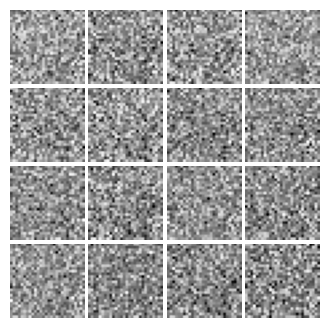

Iter-1000; D_loss: 4.957e+06; G_loss: 217.5


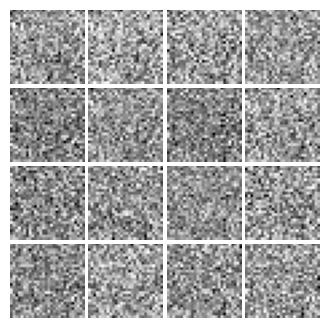

KeyboardInterrupt: ignored

In [ ]:
def sample_x(X, size):
    start_idx = np.random.randint(0, X.shape[0]-size)
    return Variable(torch.from_numpy(X[start_idx:start_idx+size]))

for it in range(1000000):
    # Sample data
    z =  Variable(torch.randn(mb_size, z_dim))
    X = sample_x(X_train, mb_size)
    X =  X.float()

    # Dicriminator
    G_sample = G(z)
    D_real = D(X)
    D_fake = D(G_sample)

    # EBGAN D loss. D_real and D_fake is energy, i.e. a number
    D_loss = D_real + nn.ReLU()(m - D_fake)
    D_loss.requires_grad_()


    # Reuse D_fake for generator loss
    D_loss.backward()
    D_solver.step()
    reset_grad()

    # Generator
    G_sample = G(z)
    D_fake = D(G_sample)

    G_loss = D_fake
    G_loss.requires_grad_()

    G_loss.backward()
    G_solver.step()
    reset_grad()

    # Print and plot every now and then
    if it % 1000 == 0:
        print('Iter-{}; D_loss: {:.4}; G_loss: {:.4}'
              .format(it, D_loss.item(), G_loss.item()))

        samples = G(z).data.numpy()[:16]

        fig = plt.figure(figsize=(4, 4))
        gs = gridspec.GridSpec(4, 4)
        gs.update(wspace=0.05, hspace=0.05)

        for i, sample in enumerate(samples):
            ax = plt.subplot(gs[i])
            plt.axis('off')
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_aspect('equal')
            plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

        if not os.path.exists('out/'):
            os.makedirs('out/')

        plt.savefig('out/{}.png'.format(str(file_name).zfill(3)), bbox_inches='tight')
        plt.show()
        file_name += 1
        plt.close(fig)

#  Boundary Equilibrium GAN

## 论文
[[1703.10717\] BEGAN: Boundary Equilibrium Generative Adversarial Networks (arxiv.org)](https://arxiv.org/abs/1703.10717)

## 网络架构
![image-20231006152840911](https://zuti.oss-cn-qingdao.aliyuncs.com/img/20231006152840.png)

## 公式


![image-20231006152947836](https://zuti.oss-cn-qingdao.aliyuncs.com/img/20231006152947.png)

![image-20231006153017483](https://zuti.oss-cn-qingdao.aliyuncs.com/img/20231006153017.png)

## 代码

导入数据和库

In [ ]:
# 导入必要的库
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
#from torchvision import datasets, transforms
#from torch.utils.data import DataLoader
import tensorflow as tf
import scipy.ndimage

# 定义超参数
mb_size = 32
z_dim = 10
X_dim = 784  # MNIST图像的维度
h_dim = 128
file_name = 0
lr = 1e-3  #learning rate
d_step = 3  # 判别器更新次数
m = 5
lam = 1e-3
k = 0
gamma = 0.5


# 数据转换和加载
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
X_train = train_images
X_train = X_train.reshape(-1, 28*28)

创建G,D

In [ ]:
G = torch.nn.Sequential(
    torch.nn.Linear(z_dim, h_dim),
    torch.nn.ReLU(),
    torch.nn.Linear(h_dim, X_dim),
    torch.nn.Sigmoid()
)

D_ = torch.nn.Sequential(
    torch.nn.Linear(X_dim, h_dim),
    torch.nn.ReLU(),
    torch.nn.Linear(h_dim, X_dim),
)


# D is an autoencoder, approximating Gaussian
def D(X):
    X_recon = D_(X)
    # Use Laplace MLE as in the paper
    return torch.mean(torch.sum(torch.abs(X - X_recon), 1))


def reset_grad():
    G.zero_grad()
    D_.zero_grad()


G_solver = optim.Adam(G.parameters(), lr=lr)
D_solver = optim.Adam(D_.parameters(), lr=lr)

开始训练

Iter-0; Convergence measure: 5.758e+04


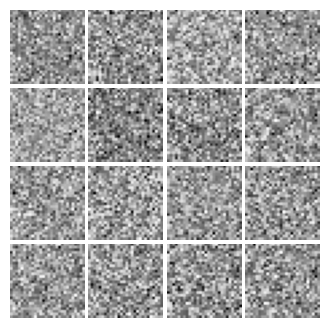

Iter-1000; Convergence measure: 5.233e+04


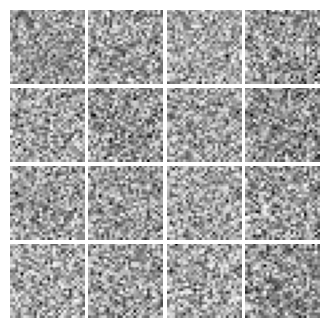

KeyboardInterrupt: ignored

In [ ]:
def sample_x(X, size):
    start_idx = np.random.randint(0, X.shape[0]-size)
    return Variable(torch.from_numpy(X[start_idx:start_idx+size]))

for it in range(1000000):
    # Sample data
    X = sample_x(X_train, mb_size)
    X =  X.float()

    # Dicriminator
    z_D = Variable(torch.randn(mb_size, z_dim))

    D_loss = D(X) - k * D(G(z_D))
    D_loss.requires_grad_()

    D_loss.backward()
    D_solver.step()
    reset_grad()

    # Generator
    z_G = Variable(torch.randn(mb_size, z_dim))

    G_loss = D(G(z_G))
    G_loss.requires_grad_()
    G_loss.backward()
    G_solver.step()
    reset_grad()

    # Update k, the equlibrium
    k = k + lam * (gamma*D(X) - D(G(z_G)))
    k = k.item()  # k is variable, so unvariable it so that no gradient prop.

    # Print and plot every now and then
    if it % 1000 == 0:
        measure = D(X) + torch.abs(gamma*D(X) - D(G(z_G)))

        print('Iter-{}; Convergence measure: {:.4}' .format(it, measure.item()))

        samples = G(z_G).data.numpy()[:16]

        fig = plt.figure(figsize=(4, 4))
        gs = gridspec.GridSpec(4, 4)
        gs.update(wspace=0.05, hspace=0.05)

        for i, sample in enumerate(samples):
            ax = plt.subplot(gs[i])
            plt.axis('off')
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_aspect('equal')
            plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

        if not os.path.exists('out/'):
            os.makedirs('out/')

        plt.savefig('out/{}.png'.format(str(file_name).zfill(3)), bbox_inches='tight')
        plt.show()
        file_name += 1
        plt.close(fig)

# Loss-Sensitive GAN

## 论文
[Loss-Sensitive Generative Adversarial Networks on Lipschitz Densities | SpringerLink](https://link.springer.com/article/10.1007/s11263-019-01265-2)

margain 先来评估距离，

## 主要思想
![image-20211114213939497](https://zuti.oss-cn-qingdao.aliyuncs.com/img/image-20211114213939497.png)

## 公式
![image-20231006192956184](https://zuti.oss-cn-qingdao.aliyuncs.com/img/20231006192956.png)

![image-20231006193147428](https://zuti.oss-cn-qingdao.aliyuncs.com/img/20231006193147.png)

![image-20231006193212886](https://zuti.oss-cn-qingdao.aliyuncs.com/img/20231006193212.png)

## 代码

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import os

# 定义超参数
batch_size = 64
nz = 100  # 维度 Z
ngf = 64  # 生成器的过滤器数量
ndf = 64  # 判别器的过滤器数量
niter = 25
lr = 0.0001
beta1 = 0.5
lambda_ = 0.0002

# 定义数据预处理
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
])

# 加载 MNIST 数据集
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True, transform=transform),
    batch_size=batch_size, shuffle=True, drop_last=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 69471045.31it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 38370508.02it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 22247321.65it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 14153438.91it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:

# 创建生成器类
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.layers = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, 1, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.layers(x)


# 创建判别器类
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(1, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False)
        )

    def forward(self, x):
        return self.layers(x)


# 创建生成器和判别器实例
generator = Generator()
discriminator = Discriminator()

# 设置优化器
optimizerG = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerD = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
# 定义损失函数
#criterion = nn.MarginRankingLoss(margin=lambda_)
criterion = nn.BCELoss()

# 训练循环
for epoch in range(niter):
    for i, (real, _) in enumerate(train_loader):
        batch_size = real.size(0)

        # -----------训练判别器---------------
        optimizerD.zero_grad()
        real = Variable(real)
        fake = generator(Variable(torch.randn(batch_size, nz, 1, 1)))

        # output_real = discriminator(real)
        # output_fake = discriminator(fake.detach())
        output_real = torch.sigmoid(discriminator(real))
        output_fake = torch.sigmoid(discriminator(fake.detach()))


        target_real = Variable(torch.ones(batch_size, 1))
        target_fake = Variable(torch.ones(batch_size, 1) * -1)

        # loss_real = criterion(output_real, output_fake, target_real)
        # loss_fake = criterion(output_fake, output_real, target_fake)
        loss_real = criterion(output_real, torch.ones_like(output_real))
        loss_fake = criterion(output_fake, torch.zeros_like(output_fake))

        loss_d = loss_real + loss_fake
        loss_d.backward()
        optimizerD.step()

        # --------------训练生成器-------------------
        # 清空梯度
        optimizerG.zero_grad()
        output_fake = torch.sigmoid(discriminator(fake))
        #output_fake = discriminator(fake)
        loss_g = criterion(output_fake, output_real)


        # 反向传播并保留计算图
        loss_g.backward()
        # 更新生成器参数
        optimizerG.step()

        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f'
              % (epoch, niter, i, len(train_loader), loss_d.item(), loss_g.item()))

        # 保存生成器模型
    if (epoch + 1) % 5 == 0:
        checkpoint_dir = 'checkpoints'
        os.makedirs(checkpoint_dir, exist_ok=True)
        torch.save(generator.state_dict(), os.path.join(checkpoint_dir, 'generator_epoch_%d.pth' % (epoch + 1)))

RuntimeError: ignored

# DC GAN

## 论文
[[1511.06434\] Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks (arxiv.org)](https://arxiv.org/abs/1511.06434)

## 主要思想


![image-20231006200808497](https://zuti.oss-cn-qingdao.aliyuncs.com/img/20231006200808.png)

![image-20231006200901230](https://zuti.oss-cn-qingdao.aliyuncs.com/img/20231006200901.png)

## 代码

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import os
from PIL import Image
import numpy as np

# 定义超参数
batch_size = 128
nz = 100  # 噪声维度
ngf = 64  # 生成器的过滤器数量
ndf = 64  # 判别器的过滤器数量
niter = 100
lr = 0.0005
beta1 = 0.9

# 定义数据预处理
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# 加载 MNIST 数据集
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True, transform=transform),
    batch_size=batch_size, shuffle=True, drop_last=True)

# 创建生成器类
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(nz, 1024),
            nn.ReLU(),
            nn.Linear(1024, 128 * 7 * 7),
            nn.BatchNorm1d(128 * 7 * 7),
            nn.ReLU(),
            nn.Unflatten(1, (128, 7, 7)),
            nn.ConvTranspose2d(128, 64, 5, 2, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, 5, 2, padding=2),
            nn.Tanh()
        )

    def forward(self, x):
        return self.layers(x)

# 创建判别器类
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(1, 64, 5, 2, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

# 创建生成器和判别器实例
generator = Generator()
discriminator = Discriminator()

# 设置优化器
optimizerG = optim.SGD(generator.parameters(), lr=lr, momentum=beta1)
optimizerD = optim.SGD(discriminator.parameters(), lr=lr, momentum=beta1)

# 定义损失函数
criterion = nn.BCELoss()

# 训练循环
def train(BATCH_SIZE):
    for epoch in range(niter):
        print("Epoch is", epoch)
        for index, (real, _) in enumerate(train_loader):
            real = Variable(real)
            batch_size = real.size(0)
            noise = Variable(torch.randn(batch_size, nz, 1, 1))

            # 训练判别器
            optimizerD.zero_grad()
            fake = generator(noise)
            label_real = Variable(torch.ones(batch_size))
            label_fake = Variable(torch.zeros(batch_size))
            output_real = discriminator(real)
            output_fake = discriminator(fake.detach())
            loss_real = criterion(output_real, label_real)
            loss_fake = criterion(output_fake, label_fake)
            loss_d = loss_real + loss_fake
            loss_d.backward()
            optimizerD.step()

            # 训练生成器
            optimizerG.zero_grad()
            output_fake = discriminator(fake)
            loss_g = criterion(output_fake, label_real)
            loss_g.backward()
            optimizerG.step()

            print("batch %d d_loss : %f" % (index, loss_d.item()))
            print("batch %d g_loss : %f" % (index, loss_g.item()))

        # 保存生成的图片
        noise = Variable(torch.randn(64, nz, 1, 1))
        generated_images = generator(noise).detach().numpy()
        generated_images = generated_images * 0.5 + 0.5
        generated_images = np.transpose(generated_images, (0, 2, 3, 1))
        img = combine_images(generated_images)
        img = img * 255.0
        img = Image.fromarray(img.astype('uint8'))
        img.save("generated_image_epoch_%d.png" % epoch)

def combine_images(generated_images):
    num = generated_images.shape[0]
    width = int(np.sqrt(num))
    height = int(np.ceil(float(num)/width))
    shape = generated_images.shape[1:3]
    image = np.zeros((height*shape[0], width*shape[1], 3), dtype=generated_images.dtype)
    for index, img in enumerate(generated_images):
        i = int(index/width)
        j = index % width
        image[i*shape[0]:(i+1)*shape[0], j*shape[1]:(j+1)*shape[1], :] = img
    return image

# 训练模型
train(batch_size)
